In [1]:
#Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


file = "WA Police Force Crime Timeseries.xlsx"
WAstats = pd.read_excel(file,sheet_name = "Data")

WAstats.fillna(0, inplace = True)

In [2]:
#list of regions
regionlist = WAstats['Website Region'].unique()
regionlist

array(['Armadale District', 'Cannington District', 'Fremantle District',
       'Goldfields-Esperance District', 'Great Southern District',
       'Joondalup District', 'Kimberley District', 'Mandurah District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Midland District', 'Mirrabooka District', 'Perth District',
       'Pilbara District', 'Regional WA Region', 'South West District',
       'Western Australia', 'Wheatbelt District'], dtype=object)

In [3]:
#list of crimes Lvl1
crimecatagories = WAstats[['WAPOL_Hierarchy_Lvl1','WAPOL_Hierarchy_Lvl2']].value_counts().reset_index()
crimecatagories.drop(columns=[0], inplace = True)

In [4]:
#list of crimes lvl2
basiccrimedesc = WAstats['WAPOL_Hierarchy_Lvl2'].unique()
basiccrimedesc

array(['Homicide', 'Recent Sexual Offences', 'Historical Sexual Offences',
       'Assault (Family)', 'Assault (Non-Family)',
       'Threatening Behaviour (Family)',
       'Threatening Behaviour (Non-Family)', 'Deprivation of Liberty',
       'Robbery', 'Burglary', 'Stealing of Motor Vehicle', 'Stealing',
       'Property Damage', 'Arson', 'Drug Offences',
       'Receiving and Possession of Stolen Property',
       'Regulated Weapons Offences', 'Graffiti',
       'Fraud & Related Offences', 'Breach of Violence Restraint Order'],
      dtype=object)

In [5]:
#Regional DF
WAstats2019 = WAstats[WAstats["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
population = {'Website Region' : ['Goldfields-Esperance District', 'Great Southern District',
        'Kimberley District', 'Mandurah District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Pilbara District', 'South West District', 'Wheatbelt District'],
    'Population': [54363, 60993,35901, 142960,1900000, 62932,62093, 179791, 73437]}
pop_df = pd.DataFrame(population)

In [6]:
Grouped = WAstats2019.groupby(['Website Region','Period','WAPOL_Hierarchy_Lvl2'])['COUNT_of_Offnc_ID'].sum().reset_index()
#Grouped['Period'] = Grouped['Period'].dt.strftime('%Y-%m')
GroupedRates = pd.merge(Grouped, pop_df,on='Website Region')
GroupedRates['Rate'] = GroupedRates['COUNT_of_Offnc_ID']/(GroupedRates['Population'])*100000
GroupedRates.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Population,Rate
0,Goldfields-Esperance District,2019-02-01,Arson,4.0,54363,7.357946
1,Goldfields-Esperance District,2019-02-01,Assault (Family),69.0,54363,126.924563
2,Goldfields-Esperance District,2019-02-01,Assault (Non-Family),40.0,54363,73.579457
3,Goldfields-Esperance District,2019-02-01,Breach of Violence Restraint Order,29.0,54363,53.345106
4,Goldfields-Esperance District,2019-02-01,Burglary,80.0,54363,147.158913


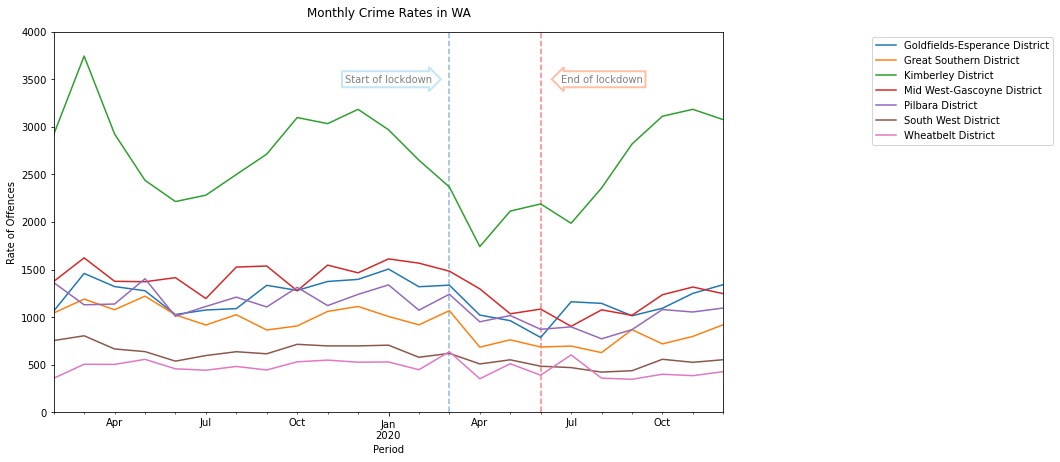

In [7]:
TotalCrimeRate = GroupedRates.groupby(['Website Region','Period'])['Rate'].sum().reset_index()
TotalCrimeRate = TotalCrimeRate[(TotalCrimeRate['Website Region']!='Metropolitan Region')&(TotalCrimeRate['Website Region']!='Regional WA Region')&(TotalCrimeRate['Website Region']!='Mandurah District')&(TotalCrimeRate['Website Region']!='Western Australia')]
TotalCrimesPivot = TotalCrimeRate.pivot(index='Period', columns='Website Region', values='Rate')
TotalCrimesPivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.5, 1.0))
plt.text(
    "2020-01", 3500, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 3500, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 4000,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 4000, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,4000)
plt.title("Monthly Crime Rates in WA", pad=15)
plt.ylabel("Rate of Offences")
plt.show()

In [8]:
timeframes = TotalCrimeRate[(TotalCrimeRate['Period']=='2020-02')|(TotalCrimeRate['Period']=='2020-04')|(TotalCrimeRate['Period']=='2020-06')]
timeframes = timeframes[["Website Region",'Period','Rate']]
timeframes
#timeframes.to_csv("timeframes.csv", encoding = "utf-8", index=False)

,Website Region,Period,Rate
12,Goldfields-Esperance District,2020-02-01,1318.911760
14,Goldfields-Esperance District,2020-04-01,1020.914961
16,Goldfields-Esperance District,2020-06-01,785.460699
35,Great Southern District,2020-02-01,918.138147
37,Great Southern District,2020-04-01,683.685013
39,Great Southern District,2020-06-01,685.324545
58,Kimberley District,2020-02-01,2648.951283
60,Kimberley District,2020-04-01,1740.898582
62,Kimberley District,2020-06-01,2189.354057
127,Mid West-Gascoyne District,2020-02-01,1566.770482


In [9]:
overallchange = timeframes.set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)


In [10]:
overallchange.reset_index(inplace=True)
Regionsinto = overallchange[overallchange['Period']=='2020-04-01']
Regionsout = overallchange[overallchange['Period']=='2020-06-01']
Regionsinto.to_csv("Regionsinto.csv", encoding = "utf-8", index=False)
Regionsout.to_csv("Regionsout.csv", encoding = "utf-8", index=False)

In [11]:
Domesticviolence = GroupedRates[((GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Assault (Family)")|(GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Threatening Behaviour (Family)"))] 
Domesticviolence = Domesticviolence.replace({'Assault (Family)':'Domestic Violence','Threatening Behaviour (Family)':'Domestic Violence'})
Domesticviolence = Domesticviolence.groupby(["Website Region",'Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
Domesticviolencecovid = Domesticviolence[((Domesticviolence["Period"]=="2020-02")|(Domesticviolence["Period"]=="2020-04")|(Domesticviolence["Period"]=="2020-06"))]


In [12]:
#Domesticviolencecovid = Domesticviolencecovid.groupby(["Website Region",'Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
Domesticviolencecovid

,Website Region,Period,WAPOL_Hierarchy_Lvl2,Rate
12,Goldfields-Esperance District,2020-02-01,Domestic Violence,172.911723
14,Goldfields-Esperance District,2020-04-01,Domestic Violence,161.874805
16,Goldfields-Esperance District,2020-06-01,Domestic Violence,158.195832
35,Great Southern District,2020-02-01,Domestic Violence,113.127736
37,Great Southern District,2020-04-01,Domestic Violence,104.930074
39,Great Southern District,2020-06-01,Domestic Violence,127.883528
58,Kimberley District,2020-02-01,Domestic Violence,693.573995
60,Kimberley District,2020-04-01,Domestic Violence,554.302109
62,Kimberley District,2020-06-01,Domestic Violence,799.420629
81,Mandurah District,2020-02-01,Domestic Violence,146.894236


In [13]:
Domesticviolencechange = Domesticviolencecovid.drop(columns="WAPOL_Hierarchy_Lvl2").set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)

In [14]:
Domesticviolencechange.reset_index(inplace=True)

In [15]:
Regionsdvin = Domesticviolencechange[Domesticviolencechange['Period']=='2020-04']
Regionsdvout = Domesticviolencechange[Domesticviolencechange['Period']=='2020-06']

In [16]:
Regionsdvin.to_csv("Regionsdvinto.csv", encoding = "utf-8", index=False)
Regionsdvout.to_csv("Regionsdvout.csv", encoding = "utf-8", index=False)

In [17]:

DVpivot = Domesticviolence.drop(columns=["WAPOL_Hierarchy_Lvl2"]).pivot(index='Period', columns='Website Region', values='Rate')

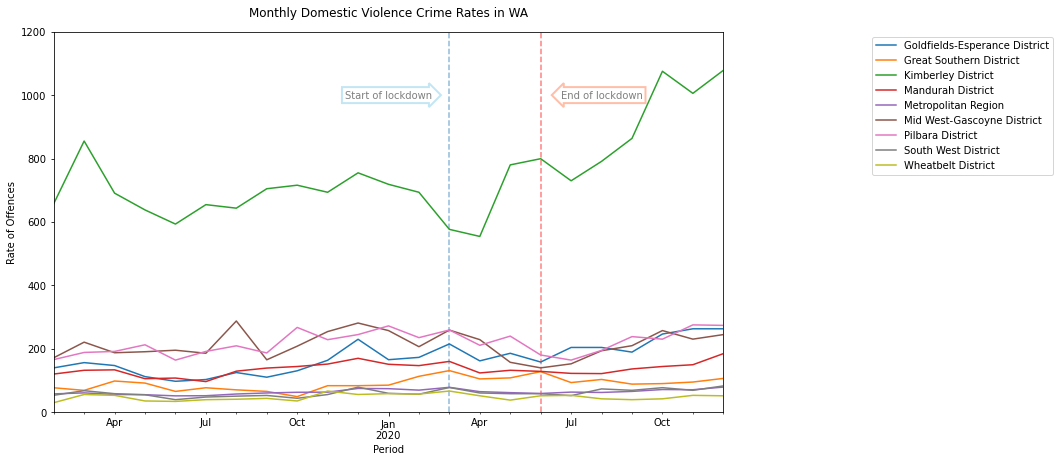

In [18]:
DVpivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.5, 1.0))
plt.text(
    "2020-01", 1000, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 1000, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 1200,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 1200, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,1200)
plt.title("Monthly Domestic Violence Crime Rates in WA", pad=15)
plt.ylabel("Rate of Offences")
plt.show()

In [19]:
sasfile = "sasexport.xlsx"
dvhomeless = pd.read_excel(sasfile,sheet_name = "Sheet1",header=3)

In [20]:
dvhomeless.fillna(method='ffill', inplace=True)

In [21]:
WAhomeless = dvhomeless[dvhomeless['State or territory of agency']=='WA']

In [22]:
WAhomeless = WAhomeless.drop(columns=['State or territory of agency'])

In [23]:
WAhomelesstotal = WAhomeless.groupby('Financial year')['Client count'].sum()

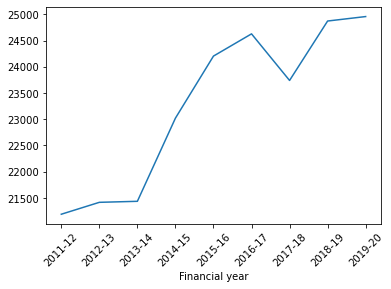

In [24]:
WAhomelesstotal.plot()
plt.xticks(rotation=45)
plt.show()

In [25]:
googlefile = "domestic violence google trend.csv"
dvgoogle = pd.read_csv(googlefile, header = 2)

In [26]:
dvgoogle

,Week,domestic violence: (Western Australia)
0,1/05/2016,100
1,8/05/2016,56
2,15/05/2016,54
3,22/05/2016,46
4,29/05/2016,9
...,...,...
255,21/03/2021,34
256,28/03/2021,17
257,4/04/2021,8
258,11/04/2021,24


In [27]:
dvgoogle['Month/Year'] = pd.to_datetime(dvgoogle['Week'], dayfirst=True).dt.to_period('M')
dvgoogle2019 = dvgoogle[dvgoogle['Month/Year']>='2019-01']
dvgoogle2019

,Week,domestic violence: (Western Australia),Month/Year
140,6/01/2019,18,2019-01
141,13/01/2019,52,2019-01
142,20/01/2019,26,2019-01
143,27/01/2019,26,2019-01
144,3/02/2019,17,2019-02
...,...,...,...
255,21/03/2021,34,2021-03
256,28/03/2021,17,2021-03
257,4/04/2021,8,2021-04
258,11/04/2021,24,2021-04


In [28]:
dvgooglemonthly2019 = dvgoogle2019.groupby('Month/Year')['domestic violence: (Western Australia)'].sum()

<AxesSubplot:xlabel='Month/Year'>

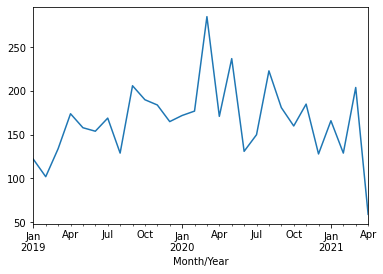

In [29]:
dvgooglemonthly2019.plot()

In [30]:
dvgooglemonthly = dvgoogle.groupby('Month/Year')['domestic violence: (Western Australia)'].sum().reset_index()

In [31]:
dvgooglemonthly

,Month/Year,domestic violence: (Western Australia)
0,2016-05,265
1,2016-06,111
2,2016-07,179
3,2016-08,217
4,2016-09,136
5,2016-10,125
6,2016-11,218
7,2016-12,120
8,2017-01,185
9,2017-02,112


In [32]:
DVcount = WAstats[WAstats["Period"]>dt.datetime(year=2016, month = 1, day = 1)]
DVcount = DVcount[(DVcount['Website Region'] == 'Western Australia')&((DVcount["WAPOL_Hierarchy_Lvl2"]=="Assault (Family)")|(DVcount["WAPOL_Hierarchy_Lvl2"]=="Threatening Behaviour (Family)"))]
DVcount = DVcount.replace({'Assault (Family)':'Domestic Violence','Threatening Behaviour (Family)':'Domestic Violence'})
DVcount = DVcount.groupby(['Period','WAPOL_Hierarchy_Lvl2'])['COUNT_of_Offnc_ID'].sum().reset_index()

In [33]:

DVcount['Month/Year'] = pd.to_datetime(DVcount['Period'], dayfirst=True).dt.to_period('M')
DVcount

,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Month/Year
0,2016-02-01,Domestic Violence,2090.0,2016-02
1,2016-03-01,Domestic Violence,2198.0,2016-03
2,2016-04-01,Domestic Violence,1903.0,2016-04
3,2016-05-01,Domestic Violence,1937.0,2016-05
4,2016-06-01,Domestic Violence,1747.0,2016-06
5,2016-07-01,Domestic Violence,1827.0,2016-07
6,2016-08-01,Domestic Violence,1818.0,2016-08
7,2016-09-01,Domestic Violence,1831.0,2016-09
8,2016-10-01,Domestic Violence,1982.0,2016-10
9,2016-11-01,Domestic Violence,2237.0,2016-11


In [34]:
dvmerge = pd.merge(DVcount,dvgooglemonthly, on= 'Month/Year')
dvmerge.head()

,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Month/Year,domestic violence: (Western Australia)
0,2016-05-01,Domestic Violence,1937.0,2016-05,265
1,2016-06-01,Domestic Violence,1747.0,2016-06,111
2,2016-07-01,Domestic Violence,1827.0,2016-07,179
3,2016-08-01,Domestic Violence,1818.0,2016-08,217
4,2016-09-01,Domestic Violence,1831.0,2016-09,136


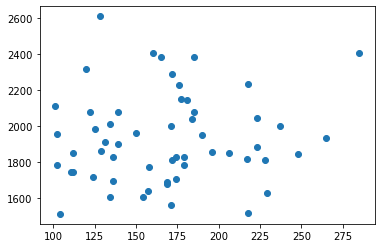

In [35]:
plt.scatter(x=dvmerge['domestic violence: (Western Australia)'], y=dvmerge['COUNT_of_Offnc_ID'])

In [36]:
googlerespectfile = "1800respect.csv"
respectsearch = pd.read_csv(googlerespectfile, header = 2)
respectsearch.head()

,Week,1800 respect: (Australia)
0,1/05/2016,0
1,8/05/2016,0
2,15/05/2016,0
3,22/05/2016,0
4,29/05/2016,41


In [37]:
respectsearch['Month/Year'] = pd.to_datetime(respectsearch['Week'], dayfirst=True).dt.to_period('M')
respectsearch2019 = respectsearch[dvgoogle['Month/Year']>='2019-01']
respectmonthly2019 = respectsearch2019.groupby('Month/Year')['1800 respect: (Australia)'].sum()

<AxesSubplot:xlabel='Month/Year'>

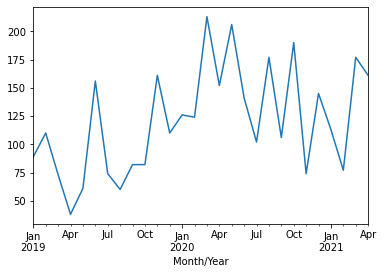

In [38]:
respectmonthly2019.plot()

In [39]:
respectmonthly = respectsearch.groupby('Month/Year')['1800 respect: (Australia)'].sum().reset_index()

In [40]:
resmerge = pd.merge(DVcount,respectmonthly, on= 'Month/Year')
resmerge.head()

,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Month/Year,1800 respect: (Australia)
0,2016-05-01,Domestic Violence,1937.0,2016-05,41
1,2016-06-01,Domestic Violence,1747.0,2016-06,98
2,2016-07-01,Domestic Violence,1827.0,2016-07,73
3,2016-08-01,Domestic Violence,1818.0,2016-08,15
4,2016-09-01,Domestic Violence,1831.0,2016-09,74


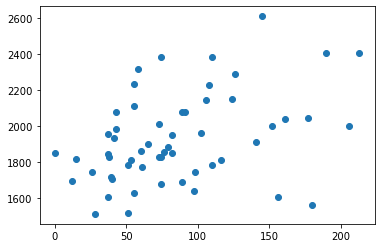

In [41]:
plt.scatter(x=resmerge['1800 respect: (Australia)'], y=resmerge['COUNT_of_Offnc_ID'])

In [76]:
totalplot = pd.merge(dvmerge,respectmonthly, on= 'Month/Year')
totalplot.rename(columns ={'COUNT_of_Offnc_ID':'Domestic Violence Offences','domestic violence: (Western Australia)':'Google Searches for domestic violence in Western Australia','1800 respect: (Australia)':'Google Searches for 1800 respect in Australia'}, inplace=True)
#totalplot['Domestic Violence Offences'] = totalplot['Domestic Violence Offences']/10

In [77]:
totalplot = totalplot.drop(columns=['WAPOL_Hierarchy_Lvl2','Month/Year'])


In [66]:
totalplot['Period']

0    2016-05-01
1    2016-06-01
2    2016-07-01
3    2016-08-01
4    2016-09-01
5    2016-10-01
6    2016-11-01
7    2016-12-01
8    2017-01-01
9    2017-02-01
10   2017-03-01
11   2017-04-01
12   2017-05-01
13   2017-06-01
14   2017-07-01
15   2017-08-01
16   2017-09-01
17   2017-10-01
18   2017-11-01
19   2017-12-01
20   2018-01-01
21   2018-02-01
22   2018-03-01
23   2018-04-01
24   2018-05-01
25   2018-06-01
26   2018-07-01
27   2018-08-01
28   2018-09-01
29   2018-10-01
30   2018-11-01
31   2018-12-01
32   2019-01-01
33   2019-02-01
34   2019-03-01
35   2019-04-01
36   2019-05-01
37   2019-06-01
38   2019-07-01
39   2019-08-01
40   2019-09-01
41   2019-10-01
42   2019-11-01
43   2019-12-01
44   2020-01-01
45   2020-02-01
46   2020-03-01
47   2020-04-01
48   2020-05-01
49   2020-06-01
50   2020-07-01
51   2020-08-01
52   2020-09-01
53   2020-10-01
54   2020-11-01
55   2020-12-01
Name: Period, dtype: datetime64[ns]

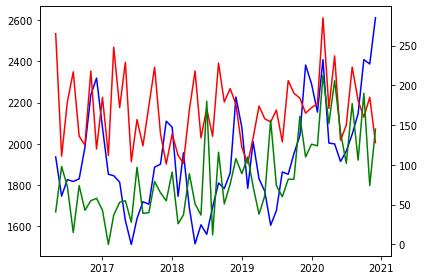

In [79]:
# totalplot.plot(figsize=(12,7))
# plt.legend(bbox_to_anchor = (1.5, 1.0))
# plt.show()


fig, ax1 = plt.subplots()

# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
ax1.plot(totalplot['Period'], totalplot['Domestic Violence Offences'],color='b')
#ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(totalplot['Period'], totalplot['Google Searches for domestic violence in Western Australia'],color ='r')
ax2.plot(totalplot['Period'], totalplot['Google Searches for 1800 respect in Australia'],color ='g')

#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


